In [1]:
import sys,os
import torch
import yaml
import logging
from pydantic import ValidationError

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd()))))))
from datasets.weather_bench import WeatherDataset
from models.VariableEncoder.datasets.dataset import CustomDataset
from models.VariableEncoder.training.configs import TrainingConfig
from models.VariableEncoder.training.configs import TrainingRunConfig

def get_normal_dataset(config: TrainingConfig):
    tgt_time_len = 1 * config.tgt_time_len
    device = ("cuda" if torch.cuda.is_available() else "cpu" )
    device = torch.device(device)

    weather = WeatherDataset(config.train_offset, device=device)
    # dataset.shape:  torch.Size([7309, 100, 1450])
    source, mean_std = weather.load_one(config.air_variable, config.surface_variable, config.only_input_variable, 
                                        config.constant_variable, config.train_start, config.train_end)
    dataset = CustomDataset(source, tgt_time_len, n_only_input=len(config.only_input_variable)+len(config.constant_variable))
    src_var_list = weather.get_var_code(config.air_variable, config.surface_variable + config.only_input_variable+config.constant_variable)
    tgt_var_list = weather.get_var_code(config.air_variable, config.surface_variable)
    return dataset, mean_std, (src_var_list, tgt_var_list)

config_path = os.path.join(os.path.dirname(os.getcwd()), 'configs/train_config.yaml')

try:
    with open(config_path) as f:
        config_dict = yaml.safe_load(f)
    config: TrainingRunConfig = TrainingRunConfig.parse_obj(config_dict)
except FileNotFoundError:
    logging.error(f"Config file {config_path} does not exist. Exiting.")
except yaml.YAMLError:
    logging.error(f"Config file {config_path} is not valid YAML. Exiting.")
except ValidationError as e:
    logging.error(f"Config file {config_path} is not valid. Exiting.\n{e}")


dataset, mean_std, var_list = get_normal_dataset(config.training)

데이터셋 불러오는 중...
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 30, longitude: 30,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float32 32.0 32.25 ... 39.0 39.25
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float32 124.0 124.2 ... 131.2
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 30, 30), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 dask.array<chunksize=(1

100%|██████████| 13/13 [00:37<00:00,  2.87s/it]


46.56094 sec
==== LOAD DATASET ====
 <xarray.Dataset>
Dimensions:                       (time: 87673, latitude: 20, longitude: 20,
                                   level: 37)
Coordinates:
  * latitude                      (latitude) float64 21.0 22.5 ... 48.0 49.5
  * level                         (level) int64 1 2 3 5 7 ... 925 950 975 1000
  * longitude                     (longitude) float64 115.5 117.0 ... 144.0
  * time                          (time) datetime64[ns] 2011-12-31 ... 2021-1...
Data variables: (12/15)
    10m_u_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    10m_v_component_of_wind       (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    2m_temperature                (time, latitude, longitude) float32 dask.array<chunksize=(128, 20, 20), meta=np.ndarray>
    geopotential                  (time, level, latitude, longitude) float32 dask.array<chunksize=(128, 

100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


25.28489 sec


In [25]:
%load_ext autoreload
%autoreload 2

from models.VariableEncoder.training.lightning import TrainModule

model = TrainModule.load_from_checkpoint('/workspace/Haea_dev/models/VariableEncoder/tb_logs/lightning_logs/1e52saa7/checkpoints/epoch=3-step=17532.ckpt')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/workspace/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize(loss: torch.Tensor, title):
    print(loss.min())
    plt.plot(loss, label="rmse loss")
    plt.title(title)
    plt.show()

torch.Size([4, 228])


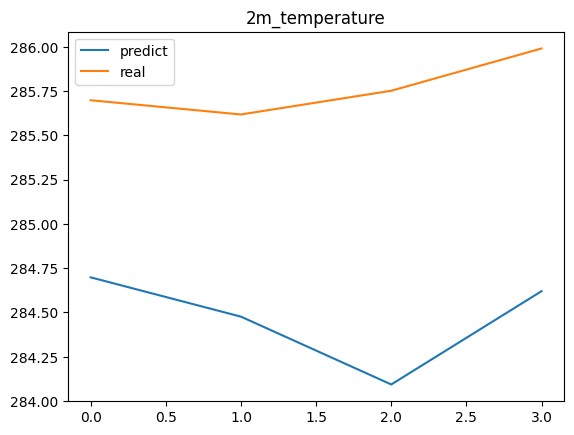

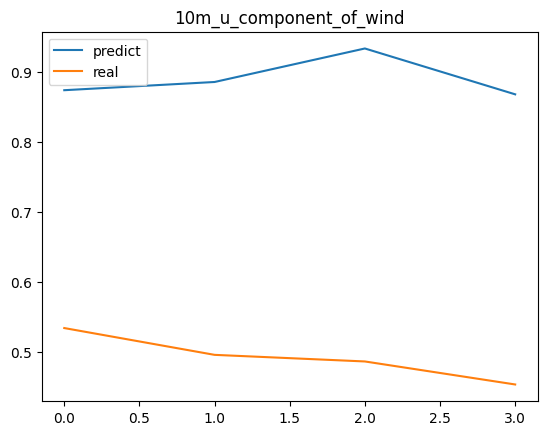

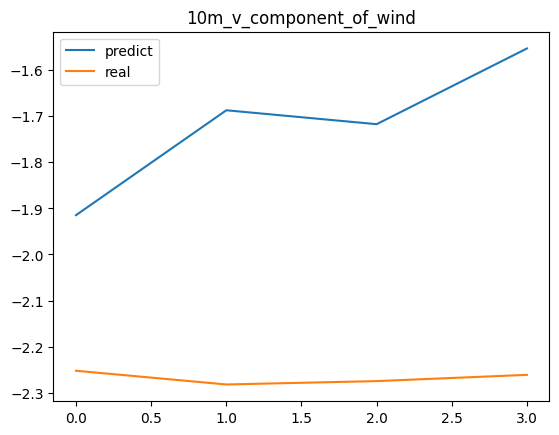

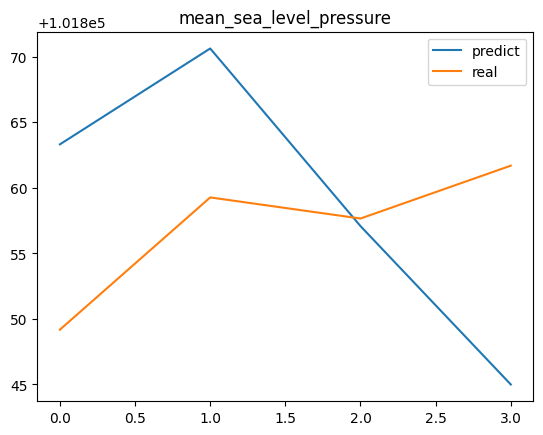

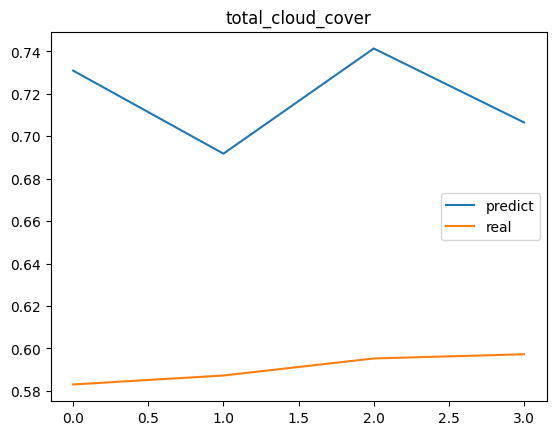

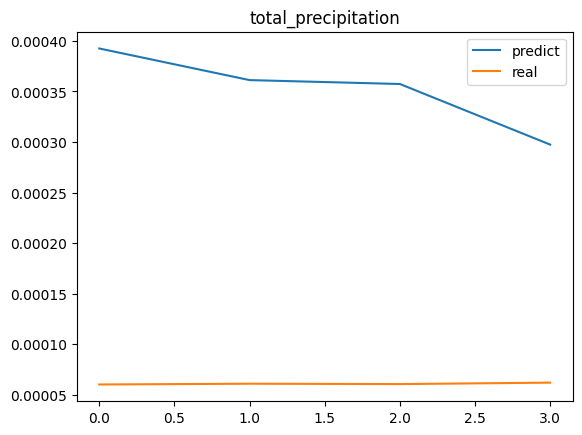

In [43]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=16, shuffle=True, drop_last=True)
device = ("cuda" if torch.cuda.is_available() else "cpu" )
device = torch.device(device)

for batch in data_loader:
    
